In [1]:
import cv2
from PIL import Image
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import math
import gtsam
import gtsam.utils.plot as gtsam_plot



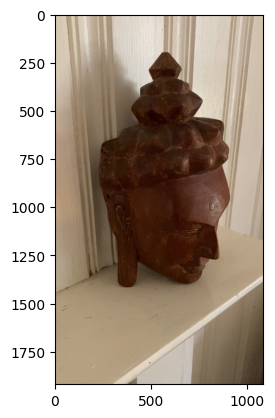

In [2]:
class ImageFetcher:
    def __init__(self,path):
        self.Images=[]
        file_list = os.listdir(path)
        sorted_file_list = sorted(file_list, key=lambda x: int(os.path.splitext(x)[0]) if x.isdigit() else x)
        for filename in sorted_file_list:
            file_path = os.path.join(path, filename)
            gray=cv2.imread(file_path)
            rgb_image = cv2.cvtColor(gray, cv2.COLOR_BGR2RGB)
            


            self.Images.append(rgb_image)
                    
imagesFolder="buddha_images"
current_directory = os.getcwd()  # Get the current working directory
full_path = os.path.join(current_directory, imagesFolder)
imagefetch=ImageFetcher(full_path)
imagelist=imagefetch.Images

plt.imshow(imagelist[0])


In [3]:
sift = cv2.SIFT_create(contrastThreshold=0.04, edgeThreshold=10)
keypoints=[]
descriptors=[]
for iterator in range(len(imagelist)):

    keypoint,descriptor=sift.detectAndCompute(imagelist[iterator], None)
    keypoints.append(keypoint)
    descriptors.append(descriptor)

In [4]:
class EssentialMatrixFinder:
    def __init__(self):
        
        self.K=np.matrix([[1690,0,imagelist[0].shape[1]/2],[0,1690,imagelist[0].shape[0]/2],[0, 0, 1]])
    

    def RecoverPoseCustom(self,E,src,dst):
        U,_,Vt=np.linalg.svd(E)
        W=np.matrix('0 -1 0;1 0 0;0 0 1')

        R1 = U @ W @ Vt
        R2 = U @ W @ Vt
        R3 = U @ W.T @ Vt
        R4 = U @ W.T @ Vt

        C1 = U[:, 2]
        C2 = -U[:, 2]
        C3 = U[:, 2]
        C4 = -U[:, 2]
        Rotation=[]
        Translation=[]
        for R, C in [(R1, C1), (R2, C2), (R3, C3), (R4, C4)]:

            C=C.reshape(-1,1)
            if np.linalg.det(R)>=1:

                Rotation.append(R)
                Translation.append(C)
            elif np.linalg.det(R)<0:

                Rotation.append(-1*R)
                Translation.append(-1*C)

        bestIdx=[]
        P1=self.K@(np.hstack((np.eye(3),np.zeros((3,1)))))
        for R,C in zip(Rotation,Translation):
            P2=self.K@np.hstack((R,C))
            pts4d=cv2.triangulatePoints(P1,P2,src.T,dst.T)
            scaledpts4d=pts4d/pts4d[3,:]
            points3d=scaledpts4d[:3]
            Z_values = R[2] @ ( points3d- C.reshape(-1,1))
            positive_Z_count = np.sum(Z_values > 0)
            bestIdx.append(positive_Z_count)

        index=np.argmax(bestIdx)
        RetR=Rotation[index]
        RetT=Translation[index]
        return RetR,RetT

    def EssentialFromDescriptor(self,des1,des2,key1,key2):
        bf=cv2.BFMatcher(cv2.NORM_L2)
        des1=np.array(des1,dtype=np.float32)
        des2=np.array(des2,dtype=np.float32)
        matches=bf.knnMatch(des1,des2,k=2)
        good_matches = []
        for m, n in matches:
            if m.distance < 0.7 * n.distance:
                good_matches.append(m)
        pts1=np.float32([key1[m.queryIdx].pt for m in good_matches])
        pts2=np.float32([key2[m.trainIdx].pt for m in good_matches])

        E,mask=cv2.findEssentialMat(pts1,pts2,self.K,cv2.RANSAC,0.999,1)
        pts1=pts1[mask.ravel()==1]
        pts2=pts2[mask.ravel()==1]
        U,S,Vt=np.linalg.svd(E)
        Ess=U@np.diag([1,1,0])@Vt
        return Ess,pts1,pts2
    
    def GetTriangulatedPoints(self,Emat,src,dst):
          """Triangulate the 2d point to 3d points"""
          R,T=self.RecoverPoseCustom(Emat,src,dst)
        #   _,R,T,_=cv2.recoverPose(E,src,dst,self.K)
    
          P1=self.K@(np.hstack((np.eye(3),np.zeros((3,1)))))
          P2=self.K@np.hstack((R,T))
          pts4d=cv2.triangulatePoints(P1,P2,src.T,dst.T)
          scaled=pts4d/pts4d[3,:]

          return scaled,P1,P2,R,T


essential=EssentialMatrixFinder()
E,Kp1,Kp2=essential.EssentialFromDescriptor(descriptors[0],descriptors[1],keypoints[0],keypoints[1])
Points3d,P1,P2,R,Trans=essential.GetTriangulatedPoints(E,Kp1,Kp2)
valid_index=Points3d[2,:]>=0
scaledFilter=Points3d[:,valid_index]
Kp1=Kp1[valid_index]
Kp2=Kp2[valid_index]

valid_index2 = (scaledFilter[0, :] >= -160) & (scaledFilter[0, :] <= 160)&\
              (scaledFilter[1, :] >= -200) & (scaledFilter[1, :] <= 200)&\
              (scaledFilter[2, :] >= -20) & (scaledFilter[2, :] <= 500)
scaledFilter[:,valid_index2]
Kp1=Kp1[valid_index2]
Kp2=Kp2[valid_index2]

corresponding={1: {tuple(Kp2[j]): tuple(scaledFilter[:, j][:3]) for j in range(len(Kp2))}}
print(corresponding)

    


{1: {(17.860752, 1440.8407): (-58.85201, 54.419178, 190.94626), (35.736378, 1537.521): (-56.551064, 64.95981, 189.9115), (51.726337, 1514.0996): (-53.94877, 61.414528, 187.05408), (56.13342, 1528.8112): (-54.96841, 64.88794, 192.6141), (59.917736, 71.880974): (-57.111614, -105.92382, 201.58669), (63.971176, 1420.1504): (-54.40403, 52.76017, 193.44453), (66.5685, 96.20877): (-54.828896, -100.21779, 196.1712), (67.822655, 106.17455): (-57.32167, -103.85202, 205.56566), (117.081474, 644.1859): (-65.94014, -49.465733, 264.12033), (117.48733, 649.2821): (-65.259995, -48.203693, 261.64926), (119.42817, 1393.8706): (-52.040733, 53.86609, 209.67805), (144.18321, 1383.0516): (-45.47926, 48.77882, 194.43678), (174.52573, 1248.7917): (-46.92414, 37.235085, 217.59917), (177.42595, 1283.3788): (-46.70595, 41.80766, 218.28578), (184.61798, 1349.9935): (-48.83594, 53.675037, 232.7857), (198.21036, 1336.0237): (-49.073578, 54.02812, 243.19693), (213.38443, 1336.7467): (-44.277794, 51.157524, 229.582),

In [5]:
import plotly.graph_objs as go



# Create a trace for the 3D scatter plot
trace = go.Scatter3d(
    x=scaledFilter[0],
    y=scaledFilter[1],
    z=scaledFilter[2],
    mode='markers',
    marker=dict(
        size=1,
        color='blue',  # Set the color of the points
        opacity=0.8
    )
)

# Create the layout for the plot with specified axis limits
layout = go.Layout(
    title='Triangulated 3D Points Visualization',
    scene=dict(
        # xaxis=dict(title='X Axis', range=[-20, 20]),  # Setting x-axis limits
        # yaxis=dict(title='Y Axis', range=[-30, 30]),  # Setting y-axis limits
        # zaxis=dict(title='Z Axis', range=[-10, 80])   # Setting z-axis limits
    )
)

# Create the figure
fig = go.Figure(data=[trace], layout=layout)

# Show the interactive plot
fig.show()

In [6]:
def find_correspondences(nextkp,actualkp, prekp):
    newnextkp = []
    new3dpts = []

    prekp_keys_tuples = [tuple(key) for key in prekp.keys()]

    
    for i in range(len(nextkp)):

        
        # Convert the key of nextkp[i] to a tuple for comparison
        next_key_tuple = tuple(nextkp[i])
        
        if next_key_tuple in prekp_keys_tuples:
            newnextkp.append(actualkp[i])
            new3dpts.append(prekp[next_key_tuple])

    return new3dpts, newnextkp


    

def FetchPointsFromDescriptors(des1,des2,kp1,kp2):
    bf=cv2.BFMatcher(cv2.NORM_L2)
    descriptor_1 = np.array(des1, dtype=np.float32)
    descriptor_2 = np.array(des2, dtype=np.float32)
    matches=bf.knnMatch(descriptor_1,descriptor_2,k=2)
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7* n.distance:
            good_matches.append(m)
    pts1 =np.float32([kp1[m.queryIdx].pt for m in good_matches])
    pts2 =np.float32([kp2[m.trainIdx].pt for m in good_matches])


    return pts1,pts2
    




In [7]:
Projections=[P1,P2]

TriArray=[scaledFilter]
K=essential.K
#### Pnp to get rest of projection matrix:
########backwardcycle#############
Rotation=[R]
Traslate=[Trans]



for i in range(1,len(imagelist)-1):


    kp3,kp4=FetchPointsFromDescriptors(descriptors[i],descriptors[i+1],keypoints[i],keypoints[i+1])
   
    new3dptin,new2dptin=find_correspondences(kp3,kp4,corresponding[i])
    new3dptin_array = np.array(new3dptin)
    new2dptin_array = np.array(new2dptin)

    sucess, rvec, tvec,inlierPNP = cv2.solvePnPRansac(new3dptin_array, new2dptin_array, K,None)
    R, _ = cv2.Rodrigues(rvec)
    Rotation.append(R)
    Traslate.append(tvec)
    pose_matrix = np.hstack((R, tvec))
    newProjection = K @ pose_matrix
    new3dptstri=cv2.triangulatePoints(Projections[-1],newProjection,kp3.T,kp4.T)
    new3dptstri=new3dptstri/new3dptstri[3,:]
    valid_index=new3dptstri[2,:]>=0
    filterednew3dptstri=new3dptstri[:,valid_index]

    filteredkp4=kp4[valid_index]

   

    TriArray.append(filterednew3dptstri)
    
    corresponding[i + 1] = {tuple(filteredkp4[idx]): tuple(filterednew3dptstri[:, idx][:3]) for idx in range(len(filteredkp4))}

    Projections.append(newProjection)







In [8]:
FinalTriarray=[]
FinalTriarray.extend(TriArray)

# forwardlen=len(TriArray)



def createPoseMatrix(rotation_array,translation_array):
    poseMatrices=[]
    for i in range(len(rotation_array)):
        rotationMatrix=rotation_array[i]
        translationMatrix=translation_array[i]
        translation_vector = translationMatrix.reshape(3)
        poseMatrix=np.eye(4)
        poseMatrix[:3,:3]=rotationMatrix
        poseMatrix[:3,3]=translation_vector
        poseMatrices.append(poseMatrix)
    return poseMatrices

forwardposes=createPoseMatrix(Rotation,Traslate)


keys=list(corresponding.keys())


In [9]:
import plotly.graph_objs as go
import numpy as np



traces = []

for i, cloud in enumerate(FinalTriarray):
    trace = go.Scatter3d(
        x=cloud[0],
        y=cloud[1],
        z=cloud[2],
        mode='markers',
        marker=dict(size=1, opacity=0.8,color='blue'),
        name=f'PointCloud {i + 1}'
    )
    traces.append(trace)

layout = go.Layout(
    title='3D Reconstructed Buddha; You can clearly see it by adjusting the axis',
    scene=dict(
        xaxis=dict(title='X Axis', range=[-160, 160]),  # Setting x-axis limits
        yaxis=dict(title='Y Axis', range=[-200, 200]),  # Setting y-axis limits
        zaxis=dict(title='Z Axis', range=[-20, 500])   # Setting z-axis limits
    )
)

fig = go.Figure(data=traces, layout=layout)
fig.show()


In [10]:
traces = []

# Plotting camera poses as axes
for i, pose in enumerate(forwardposes):
    position = pose[:3, 3]
    x_axis = pose[:3, 0] * 5 + position  # Scaling for visualization
    y_axis = pose[:3, 1] * 5 + position  # Scaling for visualization
    z_axis = pose[:3, 2] * 5 + position  # Scaling for visualization

    # Creating lines for each axis
    x_line = go.Scatter3d(
        x=[position[0], x_axis[0]],
        y=[position[1], x_axis[1]],
        z=[position[2], x_axis[2]],
        mode='lines',
        line=dict(color='red', width=2),
        name=f'X Axis {i + 1}'
    )

    y_line = go.Scatter3d(
        x=[position[0], y_axis[0]],
        y=[position[1], y_axis[1]],
        z=[position[2], y_axis[2]],
        mode='lines',
        line=dict(color='green', width=2),
        name=f'Y Axis {i + 1}'
    )

    z_line = go.Scatter3d(
        x=[position[0], z_axis[0]],
        y=[position[1], z_axis[1]],
        z=[position[2], z_axis[2]],
        mode='lines',
        line=dict(color='blue', width=2),
        name=f'Z Axis {i + 1}'
    )

    traces.extend([x_line, y_line, z_line])

layout = go.Layout(
    title='Camera Trajectory',
    scene=dict(
        xaxis=dict(title='X Axis'),  # Setting x-axis limits
        yaxis=dict(title='Y Axis'),  # Setting y-axis limits
        zaxis=dict(title='Z Axis')   # Setting z-axis limits
    )
)

fig = go.Figure(data=traces, layout=layout)
fig.show()

In [11]:
L=gtsam.symbol_shorthand.L
X=gtsam.symbol_shorthand.X

#### camera matrix

Kmat=gtsam.Cal3_S2(essential.K[0,0],essential.K[1,1],0,essential.K[0,2],essential.K[1,2])

graph=gtsam.NonlinearFactorGraph()

## set the noise model on pose and landmark factor
measurement_noise=gtsam.noiseModel.Isotropic.Sigma(2,1.0)

poseNoise=gtsam.noiseModel.Diagonal.Sigmas(
            np.array([0.3, 0.3, 0.3, 0.1, 0.1, 0.1])
        )

factor=gtsam.PriorFactorPose3(
    X(0),gtsam.Pose3(forwardposes[0]),poseNoise)
graph.push_back(factor)
countL=0
keys=list(corresponding.keys())
for i in range(len(forwardposes)):
    for j,point in enumerate(corresponding[i+1].keys()):
        factor=gtsam.GenericProjectionFactorCal3_S2(point,measurement_noise,X(i),L(countL),Kmat)
        graph.push_back(factor)
        # print(f"X{i},L{countL}")
        countL+=1


### taking scale as reference
point_noise = gtsam.noiseModel.Isotropic.Sigma(3,10)

factor = gtsam.PriorFactorPoint3(L(0), list(corresponding[1].values())[0] , point_noise)
graph.push_back(factor)
# graph.print('Factor Graph:\n')


In [12]:
countInit=0
initial_estimate = gtsam.Values()
for i, pose in enumerate(forwardposes):
    pose=gtsam.Pose3(pose)
    transformed_pose = pose.retract(0.01*np.random.randn(6, 1))
    initial_estimate.insert(X(i), transformed_pose)
  
    for j, point in enumerate(corresponding[i+1].values()):
        transformed_point = point + 0.01*np.random.randn(3)
        initial_estimate.insert(L(countInit), transformed_point)
        countInit+=1


# initial_estimate.print('Initial Estimates:\n')
params = gtsam.LevenbergMarquardtParams()
params.setVerbosity('TERMINATION')

optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimate, params)
print('Optimizing:')
result = optimizer.optimize()
# result.print('Final results:\n')
print('initial error = {}'.format(graph.error(initial_estimate)))
print('final error = {}'.format(graph.error(result)))


Optimizing:
initial error = 345117238.44506496
final error = 22848800.47064006
converged
errorThreshold: 2.28488e+07 <? 0
absoluteDecrease: 7.7069060728 <? 1e-05
relativeDecrease: 3.37300134559e-07 <? 1e-05
iterations: 8 >? 100


In [13]:

optimisedPose=[]
for i in range(len(imagelist)-1):
    Tmats=result.atPose3(X(i)).matrix()
    R=Tmats[:3,:3]
    T=Tmats[:3,3]
    optimisedPose.append((R,T))
print(len(optimisedPose))

23


In [14]:
optimized_landmarks = []
for i in range(countInit):
    optimized_landmark = result.atPoint3(L(i))
    optimized_landmarks.append(optimized_landmark)

In [15]:
import plotly.graph_objs as go
import numpy as np


traces = []

optimized_landmarks = np.array(optimized_landmarks)

trace = go.Scatter3d(
    x=optimized_landmarks[:, 0],  # X coordinates of optimized landmarks
    y=optimized_landmarks[:, 1],  # Y coordinates of optimized landmarks
    z=optimized_landmarks[:, 2],  # Z coordinates of optimized landmarks
    mode='markers',
    marker=dict(size=1, opacity=0.8, color='blue'),
    name='Optimized Landmarks'
)

traces.append(trace)

layout = go.Layout(
    title='3D Optimized Landmarks Visualization',
    scene=dict(
        xaxis=dict(title='X Axis', range=[-160, 160]),  # Setting x-axis limits
        yaxis=dict(title='Y Axis', range=[-200, 200]),  # Setting y-axis limits
        zaxis=dict(title='Z Axis', range=[-20, 500])   # Setting z-axis limits
    )
)

fig = go.Figure(data=traces, layout=layout)
fig.show()


In [16]:
import plotly.graph_objs as go

# Assuming optimisedPose contains the camera pose information

traces = []

# Plotting camera poses as axes
for i, pose in enumerate(optimisedPose):
    position = pose[1]
    x_axis = pose[0][:, 0] * 5 + position  # Scaling for visualization
    y_axis = pose[0][:, 1] * 5 + position  # Scaling for visualization
    z_axis = pose[0][:, 2] * 5 + position  # Scaling for visualization

    # Creating lines for each axis
    x_line = go.Scatter3d(
        x=[position[0], x_axis[0]],
        y=[position[1], x_axis[1]],
        z=[position[2], x_axis[2]],
        mode='lines',
        line=dict(color='red', width=2),
        name=f'X Axis {i + 1}'
    )

    y_line = go.Scatter3d(
        x=[position[0], y_axis[0]],
        y=[position[1], y_axis[1]],
        z=[position[2], y_axis[2]],
        mode='lines',
        line=dict(color='green', width=2),
        name=f'Y Axis {i + 1}'
    )

    z_line = go.Scatter3d(
        x=[position[0], z_axis[0]],
        y=[position[1], z_axis[1]],
        z=[position[2], z_axis[2]],
        mode='lines',
        line=dict(color='blue', width=2),
        name=f'Z Axis {i + 1}'
    )

    traces.extend([x_line, y_line, z_line])

layout = go.Layout(
    title='Camera Trajectory post GTSAM',
    scene=dict(
        xaxis=dict(title='X Axis'),  # Setting x-axis limits
        yaxis=dict(title='Y Axis'),  # Setting y-axis limits
        zaxis=dict(title='Z Axis')   # Setting z-axis limits
    )
)

fig = go.Figure(data=traces, layout=layout)
fig.show()
